In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [2]:
%load_ext autoreload
%autoreload 2

In [7]:
hparams = dict(
    # datamodule
    hdf_path='./data/ProteomeTools.hdf',
    batch_size=512,
    train_split=0.8,
    val_split=0.1,
    cdhit_threshold=0.5,
    cdhit_word_length=3,
    tmp_env='TMPDIR',
    num_workers=20,
    random_state=0,
    
    # model
    model_dim=128, # same size as CARP-600k
    model_depth=16,
    lr=1e-4,
    dropout=0.0, 

    # trainer
    num_gpus=1,
    max_epochs=1000,
    precision=32,
    strategy='ddp',
    es_monitor='val_cross_entropy',
    es_mode='min',
    es_patience=3,
    
    # cluster
    num_nodes=4,
    num_cpus=20,
    conda_env='MSPretraining',
    time='0-4:00:00',
    
    # tensorboard
    login_node='login-2'
)

In [8]:
args = ' '.join([f'--{k} {v}' for k,v in hparams.items()])

slurm = f'''#!/bin/bash -l 

#SBATCH --nodes={hparams['num_nodes']}
#SBATCH --gres=gpu:volta:{hparams['num_gpus']}
#SBATCH --ntasks-per-node={max(1,hparams['num_gpus'])}
#SBATCH --cpus-per-task={hparams['num_cpus']}
#SBATCH --time={hparams['time']}

#SBATCH --signal=SIGUSR1@90

source activate {hparams['conda_env']}
''' + '''
export NCCL_DEBUG=INFO
export PYTHONFAULTHANDLER=1

# Set some environment variables needed by torch.distributed 
export MASTER_ADDR=$(hostname -s)
# Get unused port
export MASTER_PORT=$(python -c 'import socket; s=socket.socket(); s.bind(("", 0)); print(s.getsockname()[1]); s.close()')

echo "MASTER_ADDR : ${MASTER_ADDR}"
echo "MASTER_PORT : ${MASTER_PORT}"
''' + f'''
srun python train.py {args}
'''

%store slurm >submit.sh

!sbatch submit.sh

Writing 'slurm' (str) to file 'submit.sh'.
Submitted batch job 17855795


In [34]:
from src.torch_helpers import start_tensorboard

start_tensorboard(login_node=hparams['login_node'])

In [35]:
from src.datamodule import MSDataModule
from src.model import MSTransformer

model = MSTransformer(**hparams)
dm = MSDataModule(**dict(model.hparams))

In [36]:
!rm -rf ./lightning_logs/version_$SLURM_JOBID

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from src.torch_helpers import NoValProgressBar

trainer = Trainer(
    gpus=1,
    precision=32,
#     log_every_n_steps=10,
    max_epochs=1,
    callbacks=[
        EarlyStopping(
            monitor=hparams['es_monitor'],
            mode=hparams['es_mode'],
            patience=hparams['es_patience']
        ),
        NoValProgressBar()
    ]
)

trainer.fit(model, dm)

Multiprocessing is handled by SLURM.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [GPU-4d627d3f-73b5-6ca6-a182-1561f2fd7b26]

  | Name    | Type      | Params
--------------------------------------
0 | encoder | ByteNetLM | 603 K 
1 | decoder | MSDecoder | 52.2 K
--------------------------------------
655 K     Trainable params
0         Non-trainable params
655 K     Total params
2.623     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3:  10%|█         | 535/5234 [2:36:44<22:56:37, 17.58s/it, loss=2.85, v_num=1.79e+7]

0it [37:28, ?it/s]in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>



Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/

Epoch 3:  10%|█         | 535/5234 [2:36:43<22:56:31, 17.58s/it, loss=2.85, v_num=1.79e+7]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
 

Epoch 3:  10%|█         | 535/5234 [2:36:43<22:56:32, 17.58s/it, loss=2.85, v_num=1.79e+7]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
 

Epoch 3:  10%|█         | 535/5234 [2:36:43<22:56:34, 17.58s/it, loss=2.85, v_num=1.79e+7]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
 

Epoch 3:  10%|█         | 535/5234 [2:36:43<22:56:35, 17.58s/it, loss=2.85, v_num=1.79e+7]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>

Epoch 3:  10%|█         | 535/5234 [2:36:43<22:56:35, 17.58s/it, loss=2.85, v_num=1.79e+7]

Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/multiprocessing/process.py", line 160, in is_alive

Traceback (most recent call last):
      File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers

  File "/home/gri

Epoch 3:  10%|█         | 535/5234 [2:36:44<22:56:37, 17.58s/it, loss=2.85, v_num=1.79e+7]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers


Epoch 3:  10%|█         | 535/5234 [2:36:44<22:56:37, 17.58s/it, loss=2.85, v_num=1.79e+7]

if w.is_alive():
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>

  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.

Epoch 3:  10%|█         | 535/5234 [2:36:44<22:56:39, 17.58s/it, loss=2.85, v_num=1.79e+7]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
 

Epoch 3:  10%|█         | 535/5234 [2:36:44<22:56:43, 17.58s/it, loss=2.85, v_num=1.79e+7]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__

  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
AssertionError: can only test a child process    
self._shutdown_workers()
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341,

Epoch 3:  10%|█         | 535/5234 [2:36:44<22:56:43, 17.58s/it, loss=2.85, v_num=1.79e+7]

<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>


Traceback (most recent call last):


Epoch 3:  10%|█         | 535/5234 [2:36:44<22:56:43, 17.58s/it, loss=2.85, v_num=1.79e+7]

  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__


  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Traceback (most recent call last):
Exception ignored in: Exception ignored in:   File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__

    Traceback (most recent call last):
self._shutdown_workers()
  

Epoch 3:  10%|█         | 535/5234 [2:36:44<22:56:44, 17.58s/it, loss=2.85, v_num=1.79e+7]


0it [37:28, ?it/s]Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
0it [37:28, ?it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in 

Epoch 3:  10%|█         | 535/5234 [2:36:44<22:56:44, 17.58s/it, loss=2.85, v_num=1.79e+7]

  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>AssertionError
: Traceback (most recent call last):
can only test a child process  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__

    self._shutdown_workers()
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
   

Epoch 3:  10%|█         | 535/5234 [2:36:45<22:56:48, 17.58s/it, loss=2.85, v_num=1.79e+7]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    : self._shutdown_workers()
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorcan only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
 

Epoch 3:  10%|█         | 535/5234 [2:36:45<22:56:48, 17.58s/it, loss=2.85, v_num=1.79e+7]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
0it [37:29, ?it/s]arent_pid == os.getpid(), 'can only test a child process'

AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()


Epoch 3:  10%|█         | 535/5234 [2:36:46<22:56:55, 17.58s/it, loss=2.85, v_num=1.79e+7]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
 

Epoch 3:  10%|█         | 535/5234 [2:36:46<22:56:55, 17.58s/it, loss=2.85, v_num=1.79e+7]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()  

Epoch 3:  10%|█         | 535/5234 [2:36:46<22:56:59, 17.58s/it, loss=2.85, v_num=1.79e+7]


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa2f85c9f70>
Traceback (most recent call last):
  File "/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
 

Epoch 0:  89%|████████▉ | 4657/5234 [34:55<04:19,  2.22it/s, loss=2.85, v_num=1.79e+7]
Validation: 0it [00:00, ?it/s]

0it [1:12:04, ?it/s]
0it [1:12:04, ?it/s]
0it [1:12:04, ?it/s]
0it [1:12:04, ?it/s]
0it [1:12:04, ?it/s]
0it [1:12:04, ?it/s]
0it [1:12:04, ?it/s]
0it [1:12:04, ?it/s]
0it [1:12:04, ?it/s]
0it [1:12:04, ?it/s]
0it [1:12:04, ?it/s]
0it [1:12:04, ?it/s]
0it [1:12:04, ?it/s]
0it [1:12:04, ?it/s]
0it [1:12:04, ?it/s]
0it [1:12:05, ?it/s]
0it [1:12:05, ?it/s]
0it [1:12:05, ?it/s]



Epoch 0: 100%|██████████| 5234/5234 [38:41<00:00,  2.25it/s, loss=2.85, v_num=1.79e+7]


In [25]:
# from tqdm import tqdm
# train_seqs = {item['sequence'] for item,_ in tqdm(zip(dm.train_dataset,range(1000)),position=0)}
# val_seqs = {item['sequence'] for item,_ in tqdm(zip(dm.val_dataset,range(1000)),position=0)}
# test_seqs = {item['sequence'] for item,_ in tqdm(zip(dm.test_dataset,range(1000)),position=0)}
# train_seqs&val_seqs, train_seqs&test_seqs, test_seqs&val_seqs

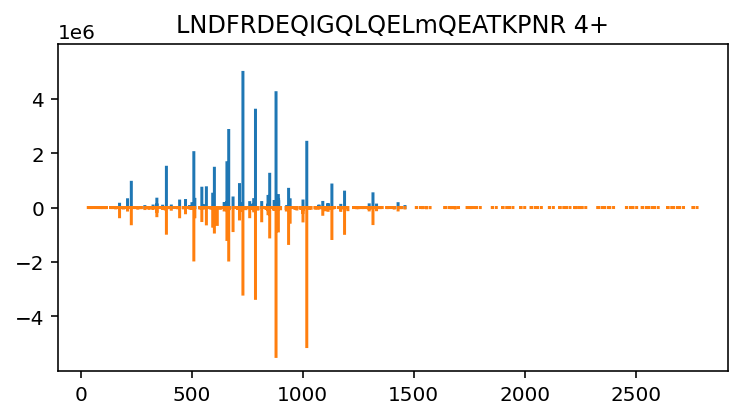

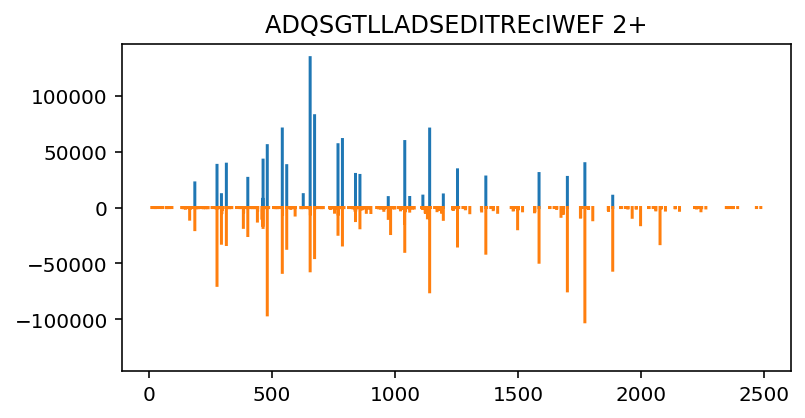

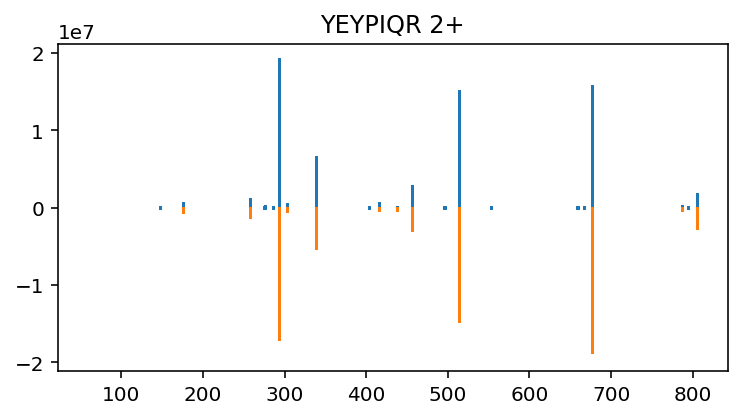

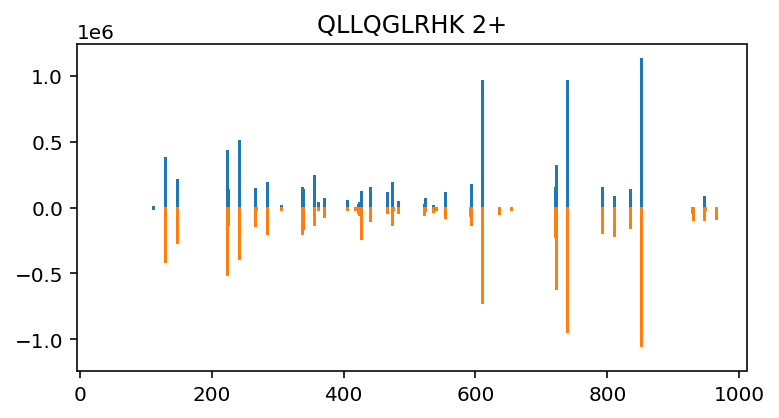

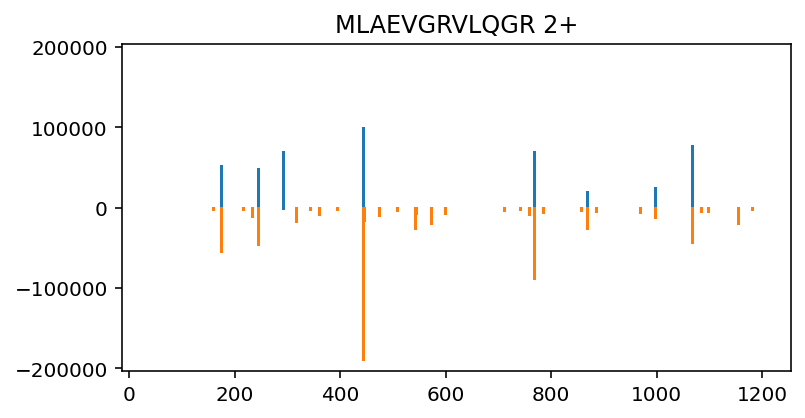

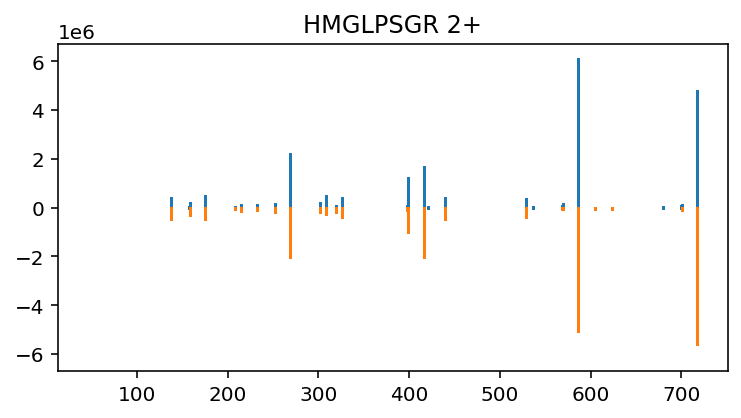

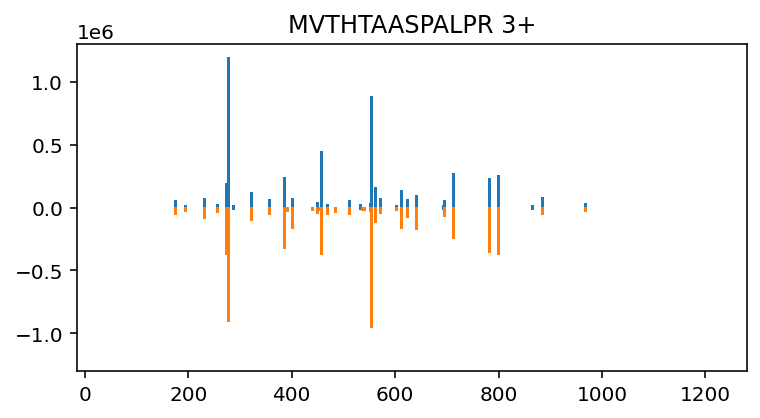

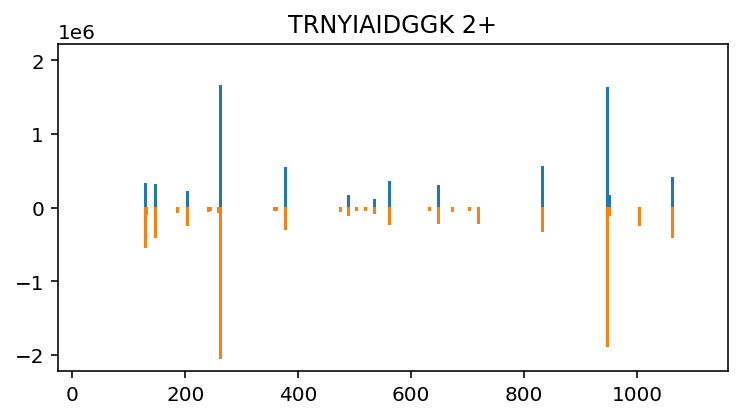

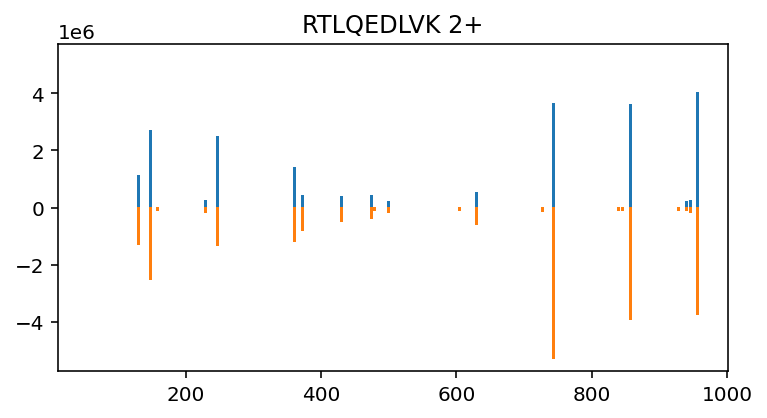

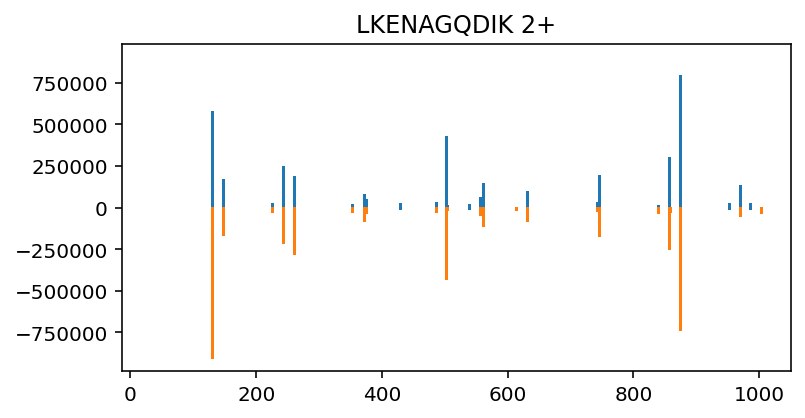

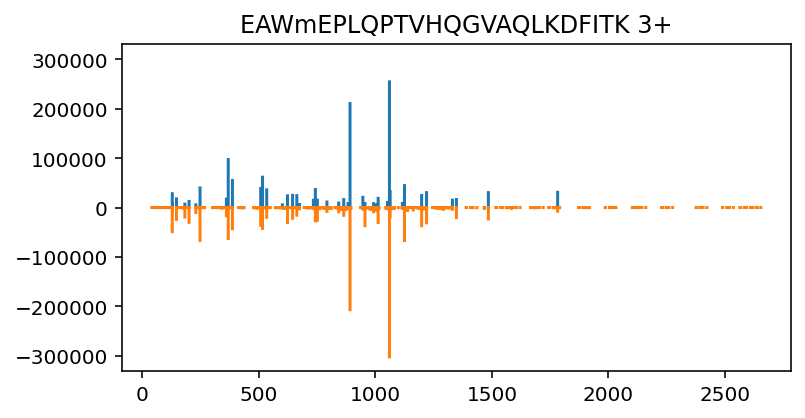

In [37]:
from src.datamodule import MSDataModule
from src.model import MSTransformer
from src.plotting import faststem
from src.spectrum import fragment_mz_tensor
from tqdm import tqdm

# [last_ckpt] = !ls -t1 ./lightning_logs/*/checkpoints/*.ckpt | head -n1
# print(last_ckpt)
# model = MSTransformer.load_from_checkpoint(last_ckpt)
# dm = MSDataModule(**dict(model.hparams))

dm.setup()

model = model.cpu()
model.eval();

for i, batch in enumerate(dm.predict_dataloader()):
    batch['y_pred'] = model.predict_step(batch)

    mz = fragment_mz_tensor(batch['sequence'][0]).ravel()
    y = batch['y'][0].detach().cpu().numpy().ravel()
    y_pred = batch['y_pred'][0].detach().cpu().numpy().ravel()
    
    plt.figure(figsize=(6,3))
    faststem(mz,y)
    faststem(mz,-y_pred)
    yl = max(np.abs(plt.ylim()))
    plt.ylim([-yl,yl])
    plt.title(f"{batch['sequence'][0]} {batch['charge'][0]}+")
    
    if i == 10:
        break

In [ ]:
# the CNN does not shrink unseen peaks to zero, while the transformer does